## Houston Home Prices ML Times Series Model (Part 1)

For this project I wanted to concentrate on a ML Time Series predictive model. This is my favorite type of model to build to date. With a background in business and finance, I truely appreciate how Time Series models help solve simpistic to complexed business problems that all companies and stakeholders face. The forecasting aspect helps to predict sales and production in the future to ensure companies are able to maximize shareholders wealth. 

I used a dataset from Zillow that contained house values from 1996 through 2018. I then converted my data into datetime data and condenced my dataset down farther to concentrate specifically in the Houston, TX area. I then wanted to investigate the following questions:

1. Is it better to invest in fast flips, under 1 year, or hold property for a few years to gain equity before selling?

2. What is the best areas in Houston to invest in?

3. Is it better to concentrate on investing in one particular area or allocate investing evenly throughout?

After I modified, cleaned, and ran my data through Pandas Profiling, I decided to use the ARIMA modeling Time Series method to predict my home values.



In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore') 
import pandas.util.testing as tm
import seaborn as sns

In [2]:
df = pd.read_csv('zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Before I start working with my data, I want to convert my dataframe into datetime data first. Converting into datetime data allows you to manipulate the data based on time, dates, months, years, and seconds. I want to do this first so that I can then use the datetime pandas commands to further investigate. 

In [3]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

Next I want to melt my data. This is a function that allows you to convert you data from wide to long. Right now I have home value averages separated by year, which makes modeling and interpretation a little tricky. By melting, I get a cumitive mean average of each home for the entire duration of years. This is condenced into one single column that now makes it easier to model. 

In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [5]:
df2 = melt_data(df)
df2

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04-01,209300.0
3901591,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04-01,225800.0
3901592,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04-01,133400.0
3901593,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,2018-04-01,664400.0


Now I am going to set my 'time' as my index.

In [6]:
df2.set_index('time', inplace=True)

In [7]:
df2

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0
...,...,...,...,...,...,...,...,...
2018-04-01,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,209300.0
2018-04-01,59107,3293,Woodstock,NH,Claremont,Grafton,14720,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,133400.0


Now I am going to create a filter to separate just the homes located in the Houston area. Houston is such a large metropolitan area that there are a few city names that are actually located in Houston even though they are not labeled as being in the city. I decided to use the column 'Metro' instead of 'City' because all of the cities located in the Houston area were close to the Houston Metro system. That was the common factor between all of the homes in the area. That way I could also get the surrounding areas as well that are located in the suburbs. 

In [8]:
filt = (df2['Metro'] == 'Houston')
houston = df2[filt]

In [9]:
houston

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,91733,77084,Houston,TX,Houston,Harris,6,95000.0
1996-04-01,91940,77449,Katy,TX,Houston,Harris,9,95400.0
1996-04-01,92036,77573,League City,TX,Houston,Galveston,23,141400.0
1996-04-01,92045,77584,Pearland,TX,Houston,Brazoria,24,138500.0
...,...,...,...,...,...,...,...,...
2018-04-01,91996,77514,Anahuac,TX,Houston,Chambers,11092,136400.0
2018-04-01,91699,77050,Houston,TX,Houston,Harris,11935,115200.0
2018-04-01,92078,77650,Port Bolivar,TX,Houston,Galveston,12195,247500.0


I love Panda Profiling! This is an easy way to conduct EDA and to explore your data more indepth with just one line of code.

In [10]:
profile = ProfileReport (houston, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

Now I am going to group my data by time and value and aggregate to a monthly mean of all the home values and plot.

In [15]:
h_mean = houston.groupby('time').aggregate({'value':'mean'})
h_mean

,value
time,
1996-04-01,136348.128342
1996-05-01,136444.919786
1996-06-01,136558.288770
1996-07-01,136700.000000
1996-08-01,136849.732620
...,...
2017-12-01,231393.048128
2018-01-01,232050.267380
2018-02-01,233325.668449


This plot shows so much information here. It's really interesting that the home values mimic the US economy. You can see a decline from 2008-2013 which was called the 08' recession, which was a direct effect on home prices and values. And a boom in Houston home values due to the historically large amount of people continously moving into the Houston area over the last few years.

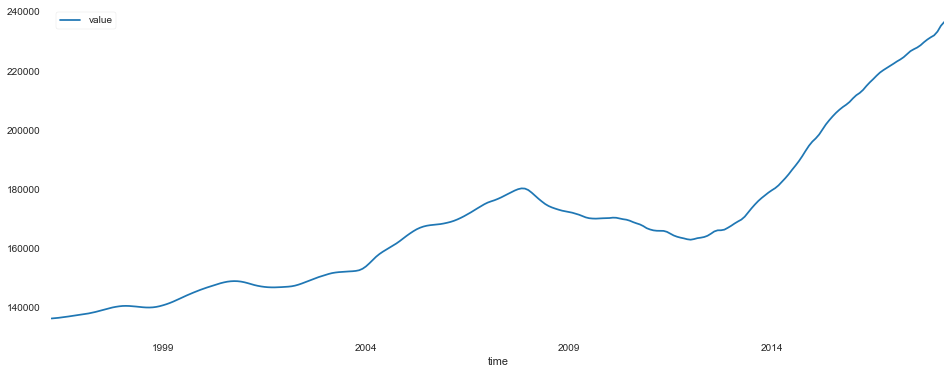

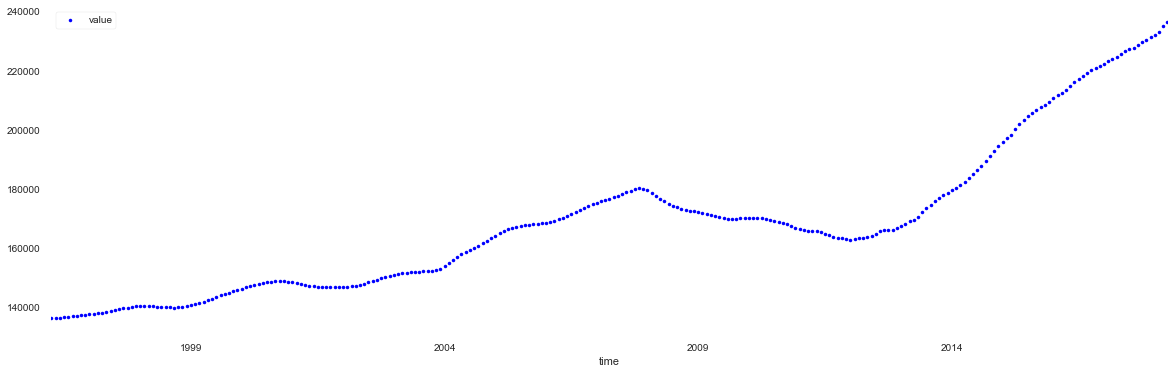

In [18]:
%matplotlib inline

h_mean.plot(figsize = (16,6));
h_mean.plot(figsize = (20,6), style = '.b');

Next I want to create a hisogram and a density plot to further look into the data.

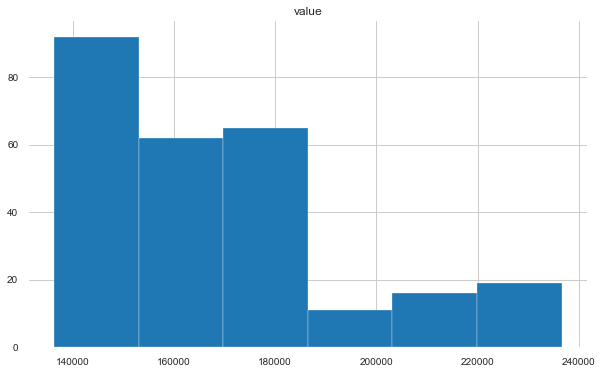

In [19]:
h_mean.hist(figsize = (10,6), bins = 6);

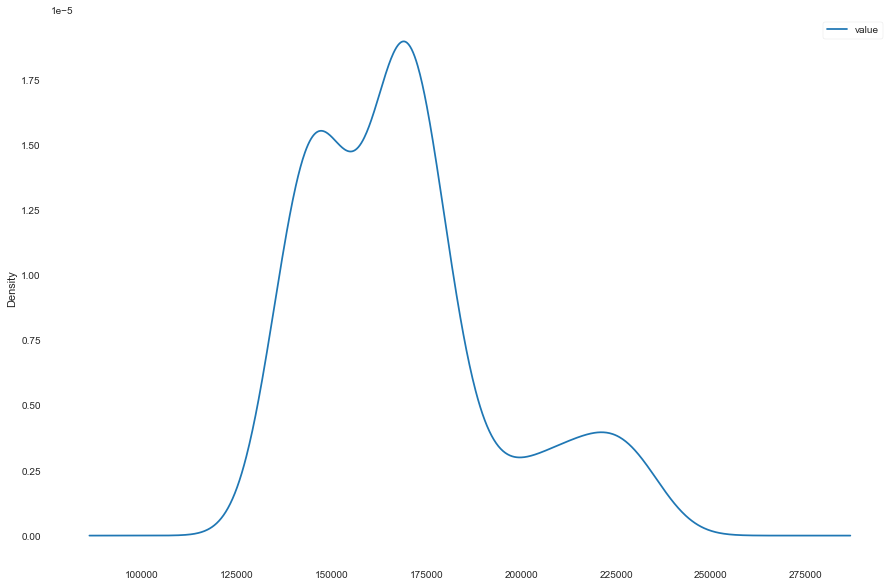

In [21]:
# Plot a density plot for nyse dataset
h_mean.plot(kind='kde', figsize = (15,10));

## Time Series Modeling

Now I am going to start my modeling. First I want to check to see if my data is stationary by preforming the Dickey-Fuller test. Making sure that your data is stationary is very important. You want your data to not have a trend when you are conducting your time series modeling. When you plot your data, it should move from left to right without trending up or down. It should have a normalized, stable movement from left to right. 

When analyzing the Dickey-Fuller test, you are going to look at the p-value results. You want your value to be as close to 0.05 as possible. That is an indicator that their is no multicolinearity and that your data is as stationary as possible. 

In [86]:
from statsmodels.tsa.stattools import adfuller

In [24]:
   def stationarity_testing(timeseries):
        
        movingAverage = timeseries.rolling(window=12, center=False).mean()
        movingSTD = timeseries.rolling(window=12, center=False).std()
        
        fig = plt.figure(figsize=(12,7))
        plt.plot(timeseries, color='blue', label='Original')
        plt.plot(movingAverage, color='red', label='Rolling Mean')
        plt.plot(movingSTD, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
        
        
        print ('Results of Dickey-Fuller Test: \n')
        dftest = adfuller(timeseries['value'], autolag='AIC')

        
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

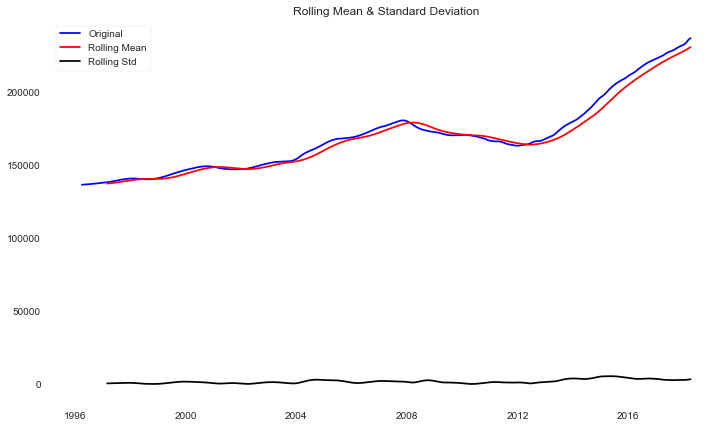

Results of Dickey-Fuller Test: 

Test Statistic                   0.151816
p-value                          0.969426
#Lags Used                      12.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [25]:
stationarity_testing(h_mean)

After conducting the Dickey-Fuller test, the p-value was 0.969426 which is way off from the 0.05 goal. I am going to run a few stationarity functions to get my data as normal as possible. Once I find the model that performs the best, I will use that model to complete my ARIMA forecast model. I creating the following additional stationarity models to compare:

1. Log

2. Differencing Simple Moving Average

3. Differencing Exponential Moving Average

4. Subtracting Previous Value with Shift()


## Log 

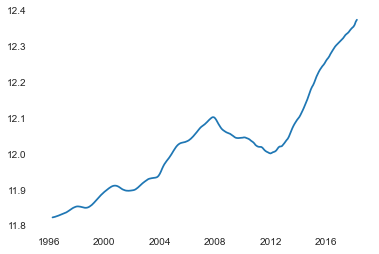

In [26]:
h_mean_logScale = np.log(h_mean)
plt.plot(h_mean_logScale)
plt.show()

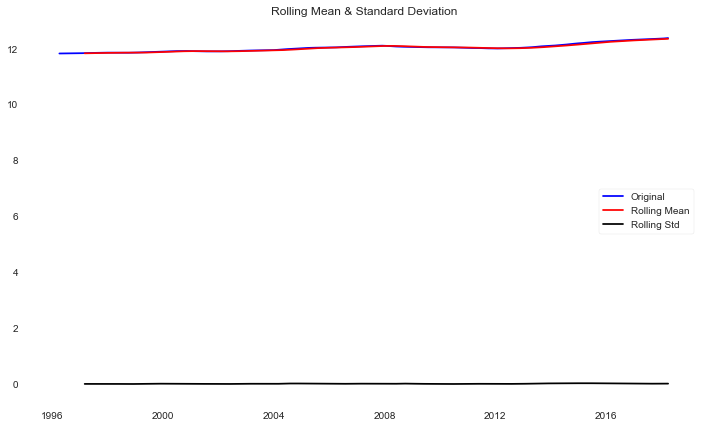

Results of Dickey-Fuller Test: 

Test Statistic                  -0.040164
p-value                          0.955082
#Lags Used                      12.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [27]:
stationarity_testing(h_mean_logScale)

## Differencing Simple Moving Average

In [28]:
movingAverage = h_mean_logScale.rolling(window=12).mean()
datasetLogScale_movingaverage = h_mean_logScale - movingAverage
datasetLogScale_movingaverage.head(12)

datasetLogScale_movingaverage.dropna(inplace=True)
datasetLogScale_movingaverage.head(12)

,value
time,
1997-03-01,0.006676
1997-04-01,0.007154
1997-05-01,0.007802
1997-06-01,0.008606
1997-07-01,0.009394
1997-08-01,0.010089
1997-09-01,0.010528
1997-10-01,0.010742
1997-11-01,0.010575


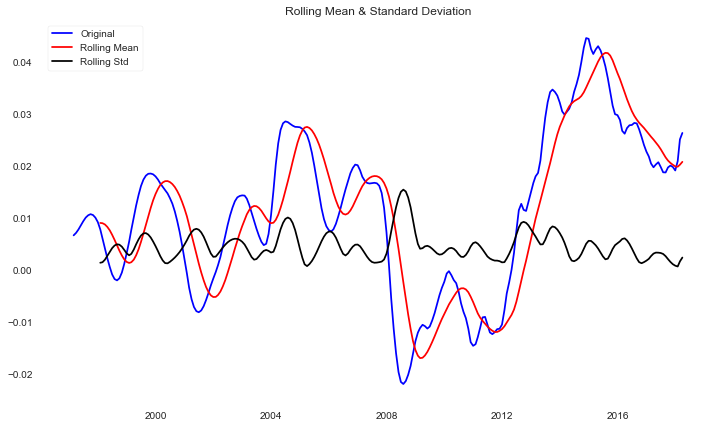

Results of Dickey-Fuller Test: 

Test Statistic                  -1.536016
p-value                          0.515625
#Lags Used                      16.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [29]:
stationarity_testing(datasetLogScale_movingaverage)

## Differencing Exponential Moving Average

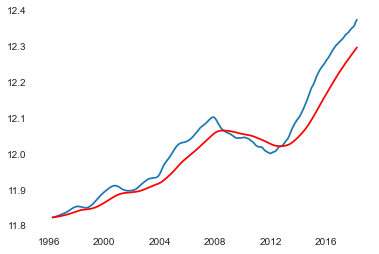

In [30]:
exponentialmovingaverage = h_mean_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(h_mean_logScale)
plt.plot(exponentialmovingaverage, color='red')
plt.show()

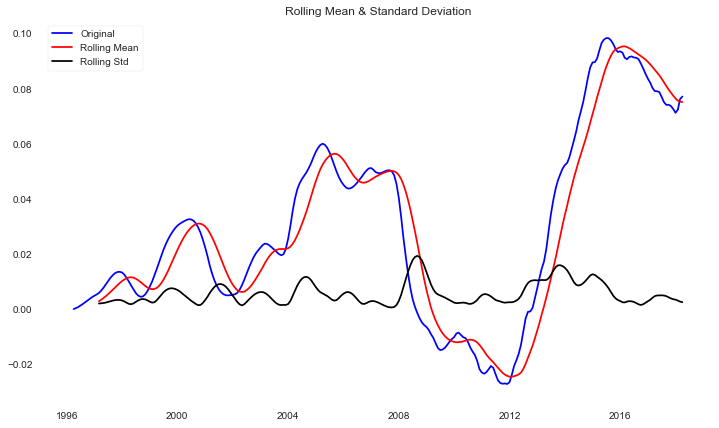

Results of Dickey-Fuller Test: 

Test Statistic                  -2.068383
p-value                          0.257416
#Lags Used                      12.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [31]:
datasetLogScale_ex_movingaverage = h_mean_logScale - exponentialmovingaverage
stationarity_testing(datasetLogScale_ex_movingaverage)

## Subtracting Previous Value with Shift()

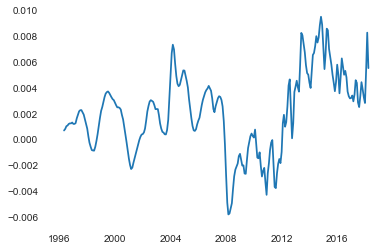

In [32]:
datasetLogDiffShifting = h_mean_logScale - h_mean_logScale.shift()
plt.plot(datasetLogDiffShifting)
plt.show()

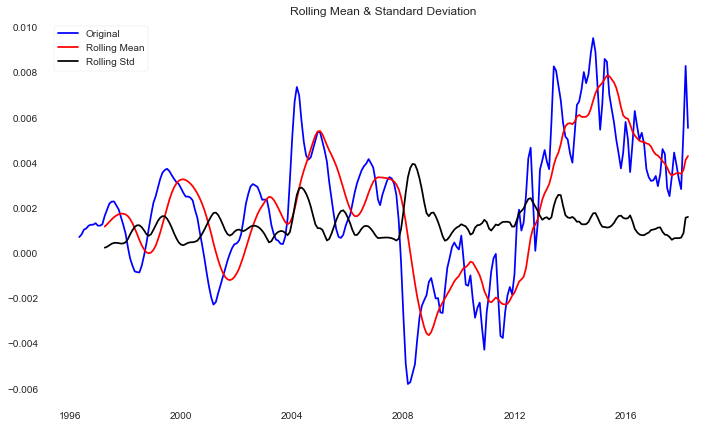

Results of Dickey-Fuller Test: 

Test Statistic                  -2.349191
p-value                          0.156593
#Lags Used                      11.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [33]:
datasetLogDiffShifting.dropna(inplace=True)
stationarity_testing(datasetLogDiffShifting)

Once I completed all of my stationarity modeling, the Subtracting Previous Value with Shift() model preformed the best. I did not get my p-value as low as I would have liked but it was not too terrible at 0.156593. I am now going to start my auto and partial autocorrelation and ARIMA model.

An ARIMA model is characterized by 3 terms: p, d, q


p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

After completing the auto and partial autocorrelation modeling, I will be able to determine what the p, q, and d values should be. By tweaking these numbers, I will also be able to adjust for the fact that my data was not as stationary as I would have liked. 

## Auto and Partial Autocorrelation Modeling

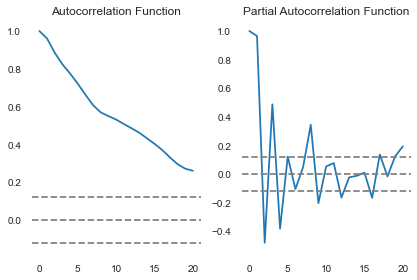

In [34]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [35]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [36]:
arma_order_select_ic(datasetLogDiffShifting)

{'bic':              0            1            2
 0 -2304.287799 -2638.291931 -2917.322331
 1 -2987.831277 -3113.643587 -3132.923293
 2 -3047.081638 -3113.156178 -3149.286541
 3 -3099.651384 -3125.884250 -3151.508309
 4 -3128.043023 -3126.704166 -3146.868067, 'bic_min_order': (3, 2)}

# AR Model (Delete)

Plotting AR Model


Text(0.5, 1.0, 'RSS: 0.0001')

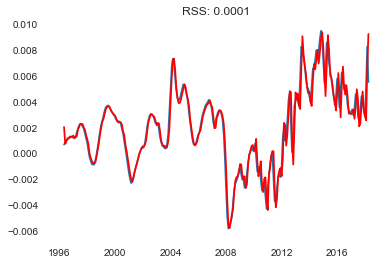

In [37]:
from statsmodels.tsa.arima_model import ARIMA

print('Plotting AR Model')
model = ARIMA(h_mean_logScale, order=(2, 1, 0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['value'])**2))

The results gave me a 0, 1, 2 order for my ARIMA model. I played around with the numbers slightly and finally went with a 2, 1, 2 order instead to get an RSS result of 0.0001

I used the log values in my model and then converted them back at the end into its orginial values for easy interpretation and to fit and plot my predictions against my orginial values.

## ARIMA Model

In [87]:
from statsmodels.tsa.arima_model import ARIMA

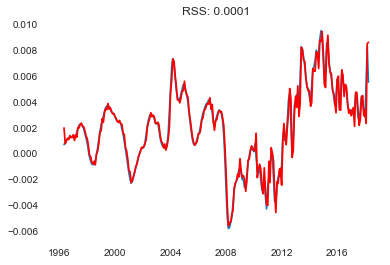

In [39]:
model = ARIMA(h_mean_logScale, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['value'])**2))
plt.show()

In [40]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

time
1996-05-01    0.001988
1996-06-01    0.000770
1996-07-01    0.000989
1996-08-01    0.001193
1996-09-01    0.001099
dtype: float64


In [41]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head)

<bound method NDFrame.head of time
1996-05-01    0.001988
1996-06-01    0.002758
1996-07-01    0.003747
1996-08-01    0.004940
1996-09-01    0.006039
                ...   
2017-12-01    0.528453
2018-01-01    0.531807
2018-02-01    0.534157
2018-03-01    0.542668
2018-04-01    0.551298
Length: 264, dtype: float64>


In [42]:
predictions_ARIMA_log = pd.Series(h_mean_logScale['value'].iloc[0], index = h_mean_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

time
1996-04-01    11.822967
1996-05-01    11.824955
1996-06-01    11.825725
1996-07-01    11.826713
1996-08-01    11.827907
dtype: float64

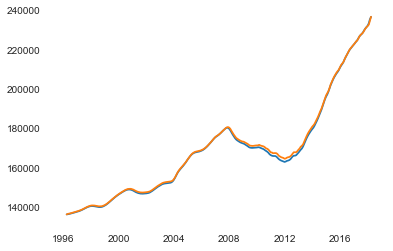

In [43]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(h_mean)
plt.plot(predictions_ARIMA)
plt.show()

In [44]:
h_mean_logScale.head()

,value
time,
1996-04-01,11.822967
1996-05-01,11.823676
1996-06-01,11.824507
1996-07-01,11.825544
1996-08-01,11.826639


In [45]:
predictions_ARIMA_log.tail()

time
2017-12-01    12.351420
2018-01-01    12.354774
2018-02-01    12.357123
2018-03-01    12.365634
2018-04-01    12.374265
dtype: float64

In [46]:
h_mean_logScale.tail()

,value
time,
2017-12-01,12.351873
2018-01-01,12.354709
2018-02-01,12.360190
2018-03-01,12.368480
2018-04-01,12.374022


In [47]:
h_mean.shape

(265, 1)

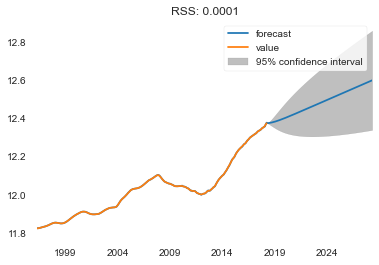

(array([12.37485647, 12.37495869, 12.37565121, 12.37631695, 12.37720422,
        12.37817947, 12.37928149, 12.3804747 , 12.38175863, 12.383119  ,
        12.38454926, 12.38604085, 12.38758736, 12.38918257, 12.39082118,
        12.39249835, 12.39420985, 12.39595188, 12.39772106, 12.3995144 ,
        12.40132923, 12.40316318, 12.40501413, 12.40688021, 12.40875974,
        12.41065125, 12.41255341, 12.41446504, 12.41638509, 12.41831264,
        12.42024686, 12.42218701, 12.42413244, 12.42608256, 12.42803686,
        12.42999487, 12.43195619, 12.43392044, 12.43588731, 12.43785651,
        12.43982777, 12.44180088, 12.44377562, 12.44575182, 12.44772932,
        12.44970796, 12.45168764, 12.45366822, 12.45564962, 12.45763173,
        12.45961449, 12.46159783, 12.46358166, 12.46556595, 12.46755065,
        12.4695357 , 12.47152107, 12.47350672, 12.47549262, 12.47747875,
        12.47946507, 12.48145158, 12.48343824, 12.48542504, 12.48741197,
        12.489399  , 12.49138614, 12.49337336, 12.4

In [48]:
results_ARIMA.plot_predict(1,385)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['value'])**2))
plt.show()
results_ARIMA.forecast(steps=120)

I was very pleased with my outcome. I wanted to compare my predicted home values to the original home values and I was off no more than $700 each year. 

In [57]:
predictions_ARIMA.tail()

time
2017-12-01    231288.124285
2018-01-01    232065.261273
2018-02-01    232611.139082
2018-03-01    234599.334635
2018-04-01    236632.766481
dtype: float64

In [58]:
h_mean.tail()

,value
time,
2017-12-01,231393.048128
2018-01-01,232050.267380
2018-02-01,233325.668449
2018-03-01,235267.914439
2018-04-01,236575.401070


In [65]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1591.371
Method:                       css-mle   S.D. of innovations              0.001
Date:                Fri, 14 Aug 2020   AIC                          -3170.742
Time:                        10:50:40   BIC                          -3149.287
Sample:                    05-01-1996   HQIC                         -3162.121
                         - 04-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      2.616      0.009       0.000       0.003
ar.L1.D.value     0.4450      0.075      5.940      0.000       0.298       0.592
ar.L2.D.value     0.3955      0.074      5.337      0.000       0.250       0.541
ma.L1.D.value     1.6282      0.045     36.048      0.000       1.540       1.717
ma.L2.D.value     0.8995      0.043     20.870      0.000       0.815       0.984
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1241           +0.0000j            1.1241            0.0000
AR.2           -2.2494           +0.0000j            2.2494            0.5000
MA.1           -0.9051           -0.5409j            1.0544           -0.4143
MA.2           -0.9051           +0.5409j            1.0544            0.4143
-----------------------------------------------------------------------------
"""

# Conclusion

There were different time series modeling options I could have used but I decided to use the ARIMA model because it seemed to preform very well. ARIMA stands for AutoRegressive Integrated Moving Average, which is considered a linear regression model, and its a forecasting algorithm based on the information from past values that can be used to predict future values. It is also the most popular model to use in time series modeling. 

Me adjusting my p, d, q order from (0, 1, 2) to (2, 1, 2) seemed to help my model fit very well. I had a RSS score of 0.0001 which is very good and translates to producing a variance of no more than $700 off from the original home value and my model's predicted home values. 

This notebook is part 1 to my project. I broke up my EDA and my modeling into two different notebooks to keep everything organized. To see my conclusions and business recommendations, go to my part 2 notebook for this project.